<a href="https://colab.research.google.com/github/Jackyscy/cv/blob/main/CNN_trial_multiD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate, Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D,Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [3]:
df = pd.read_csv('GT data for 3-hour intervel learning1_selected_RFECV_Screened.csv',
                 usecols=['Combust Monitor Actual Spread 1', 'Turb Exhaust T1', 'Turb Exhaust T3',
                 'Turb Exhaust T6', 'Turb Exhaust T7',
                  'Turb Exhaust T10', 'Turb Exhaust T12',
                  'Turb Exhaust T13','Turb Exhaust T16',
                  'Turb Exhaust T17','Turb Exhaust T18','Turb Exhaust T20',
                  'Turb Exhaust T21','Turb Exhaust T23',
                 'Turb Exhaust T24','Turb Exhaust T25','Turb Exhaust T26',
                 'Turb Exhaust T28' ,'Turb Exhaust T30' ,'GT Exhaust Outlet temp Expected'
                 ,'GT Swirl Angle' ,'Turbine Speed in RPM'
                 ,'GT IGV Position']
        )


In [4]:
df["LogSpread1"] = np.log(df['Combust Monitor Actual Spread 1'])
df['DiffLogSpread1'] = df['LogSpread1'].diff()

In [5]:
#df = df.drop(df.index[0])

df.head()

,Combust Monitor Actual Spread 1,Turb Exhaust T1,Turb Exhaust T3,Turb Exhaust T6,Turb Exhaust T7,Turb Exhaust T10,Turb Exhaust T12,Turb Exhaust T13,Turb Exhaust T16,Turb Exhaust T17,...,Turb Exhaust T25,Turb Exhaust T26,Turb Exhaust T28,Turb Exhaust T30,GT Exhaust Outlet temp Expected,GT Swirl Angle,Turbine Speed in RPM,GT IGV Position,LogSpread1,DiffLogSpread1
0,31.056818,617.558472,623.100586,629.324280,624.259338,617.558472,627.371765,630.132446,627.494080,628.687927,...,599.927612,619.758606,630.743225,623.573059,603.800964,34.020233,2997.721680,87.996284,3.435818,NaN
1,29.123943,617.433899,620.316772,631.588562,623.166626,617.433899,627.501770,629.799194,628.516724,628.578430,...,601.245728,617.748657,629.842468,623.936646,605.027405,34.331245,2998.596436,87.994431,3.371561,-0.064258
2,29.981073,617.737305,620.644348,632.476074,623.707764,617.737305,627.640869,630.010315,629.325317,629.040100,...,600.664917,620.678833,629.604981,623.119141,604.687195,33.852203,3002.304688,87.991333,3.400566,0.029006
3,29.942198,616.953918,621.066834,631.418030,620.302856,616.953918,629.929077,630.754028,630.473572,628.815063,...,603.965210,622.835266,633.817627,624.053040,605.127502,35.938599,2998.558350,88.001442,3.399269,-0.001298
4,27.763840,616.664490,619.643860,631.285461,621.734375,616.664490,627.481384,628.682434,629.238647,627.473755,...,602.722046,622.654175,630.037903,622.457703,605.055359,35.666512,3001.869141,88.000969,3.323734,-0.075534


In [6]:
df.shape[1]

25

In [ ]:
#input_data = df[['GT Exhaust Outlet Temp', 'GT Exhaust Outlet temp Expected',
               #  'Combust Monitor Actual Spread 3', 'GT Exhaust Outlet temp Average',
               #   'GT Swirl Angle', 'GT Exhaust Outlet Temp',
               #   'GT Efficiency Actual (LHV)','Turbine Speed in RPM',
               #   'GT Compres Disch Press','GT Fuel Gas Mass Flow','GT IGV Position',
               #   'GT Turbine Inlet Temp','GT Gross MW',
               #  'LogSpread1','DiffLogSpread1' ]].values

#targets =df['DiffLogSpread1'].values

In [7]:
#input_data.shape

df.shape

(2859, 25)

In [ ]:
#targets =df['DiffLogSpread1'].values

In [8]:
#T = 10
#D = input_data.shape[1]
#N = len(input_data)-T

T = 10
D = df.shape[1]
N = len(df)-T


In [9]:
#Ntest = 21
#train = input_data[:-Ntest]
#test = input_data[-Ntest:]
#train.shape

Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
train.shape


(2838, 25)

In [11]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
# Make supervised dataset

input_data = df[['Combust Monitor Actual Spread 1','Turb Exhaust T1', 'Turb Exhaust T3',
                 'Turb Exhaust T6', 'Turb Exhaust T7',
                  'Turb Exhaust T10', 'Turb Exhaust T12',
                  'Turb Exhaust T13','Turb Exhaust T16',
                  'Turb Exhaust T17','Turb Exhaust T18','Turb Exhaust T20',
                  'Turb Exhaust T21','Turb Exhaust T23',
                 'Turb Exhaust T24','Turb Exhaust T25','Turb Exhaust T26',
                 'Turb Exhaust T28' ,'Turb Exhaust T30' ,'GT Exhaust Outlet temp Expected'
                 ,'GT Swirl Angle' ,'Turbine Speed in RPM'
                 ,'GT IGV Position',"LogSpread1",'DiffLogSpread1'
                ]].dropna().to_numpy()

targets =df['DiffLogSpread1'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(input_data) - T):
  x = input_data[t:t+T,:]
  X.append(x)
  y = targets[t+T]

  Y.append(y)

X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2848, 10, 25) Y.shape (2848,)


In [ ]:
#Xtrain = np.zeros((len(input_data)-Ntest,T,D))
#Ytrain = np.zeros(len(input_data)-Ntest)

#for t in range (len(input_data)-Ntest):
  #Xtrain[t,:,:] = input_data[t:t+T]
  #Ytrain[t] = (targets[t+T])

In [ ]:
#Xtest = np.zeros((Ntest, T, D))
#Ytest = np.zeros(Ntest)

#for u in range(Ntest):
 # t = u + len(input_data)-Ntest
 # Xtest[u,:,:] = input_data[t:t+T]
 # Ytest[u] = (targets[t+T])

In [13]:
Xtrain, Ytrain = X[:-Ntest,:,:], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:,:,:], Y[-Ntest:]


In [14]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 25)]          0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             1216      
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33    

In [16]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [17]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=200,
  validation_data=(Xtest, Ytest)
)

Epoch 1/200
89/89 [==============================] - 1s 4ms/step - loss: 2966.2476 - val_loss: 3.1149
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 4.3429 - val_loss: 1.5773
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 4.2175 - val_loss: 1.7441
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 4.1610 - val_loss: 1.8579
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 4.0021 - val_loss: 1.1558
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 3.8445 - val_loss: 1.1391
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 3.7699 - val_loss: 1.0016
Epoch 8/200
89/89 [==============================] - 0s 2ms/step - loss: 3.6357 - val_loss: 0.9148
Epoch 9/200
89/89 [==============================] - 0s 2ms/step - loss: 3.4762 - val_loss: 2.4432
Epoch 10/200
89/89 [==============================] - 0s 2ms/step - loss: 3.3867 - val_loss: 0.7609
Epoch 

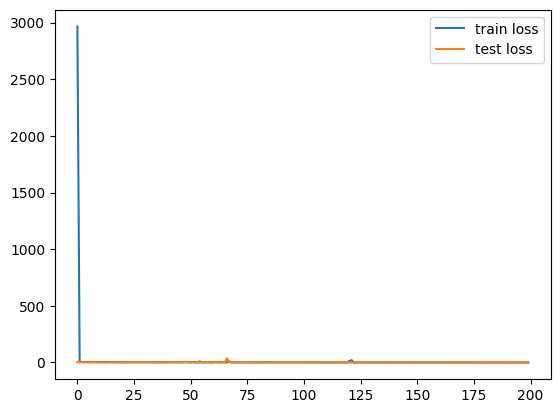

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [19]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [20]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 20ms/step


In [21]:
# Store diff predictions
df.loc[train_idx, 'Diff CNN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff CNN Test Prediction'] = Ptest

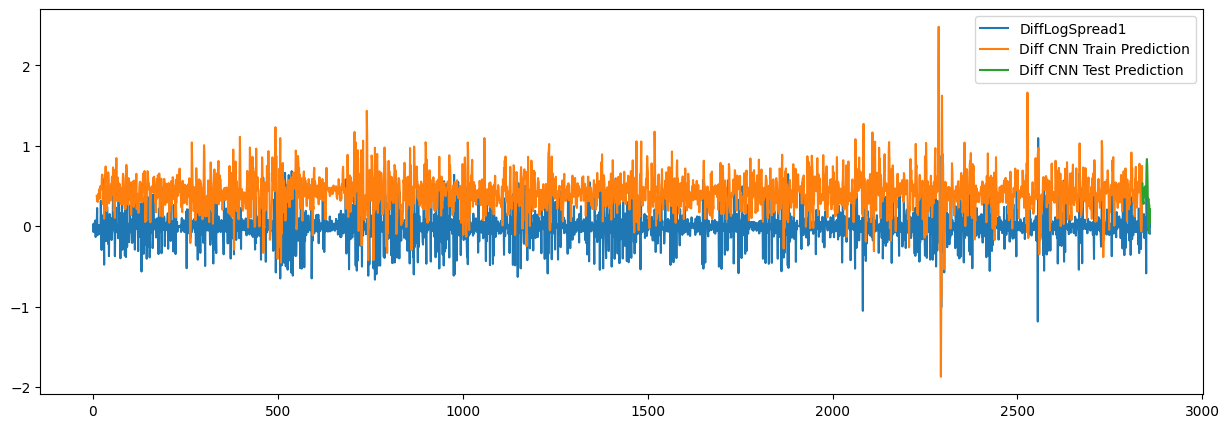

In [22]:
cols = ['DiffLogSpread1',
        'Diff CNN Train Prediction',
        'Diff CNN Test Prediction']
df[cols].plot(figsize=(15, 5));


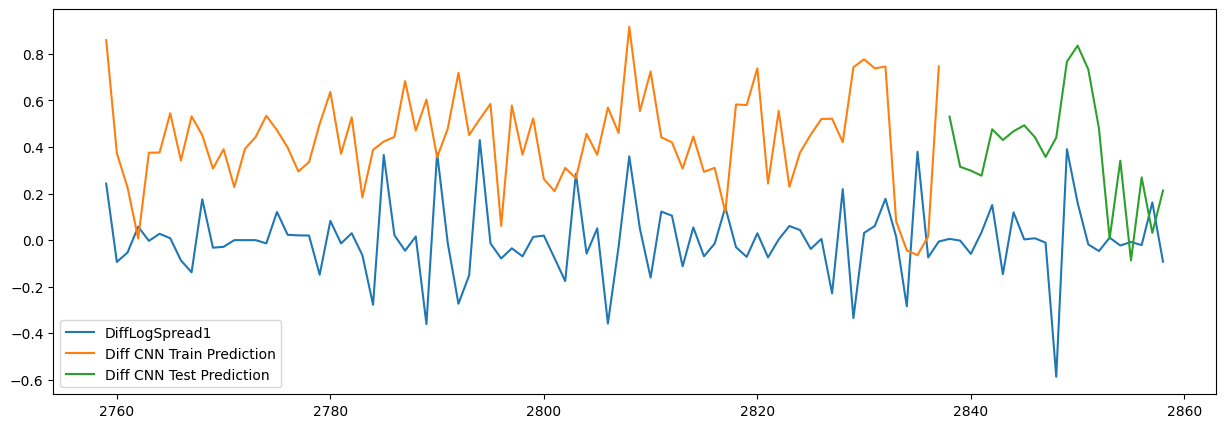

In [23]:
# plot 1-step forecast
df.iloc[-100:][['DiffLogSpread1', 'Diff CNN Train Prediction', 'Diff CNN Test Prediction']].plot(figsize=(15, 5));

In [24]:
# Needed to compute un-differenced predictions
df['ShiftLogSpread1'] = df['LogSpread1'].shift(1)
prev = df['ShiftLogSpread1']

In [25]:
# Last-known train value
last_train = train.iloc[-1]['LogSpread1']

In [26]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

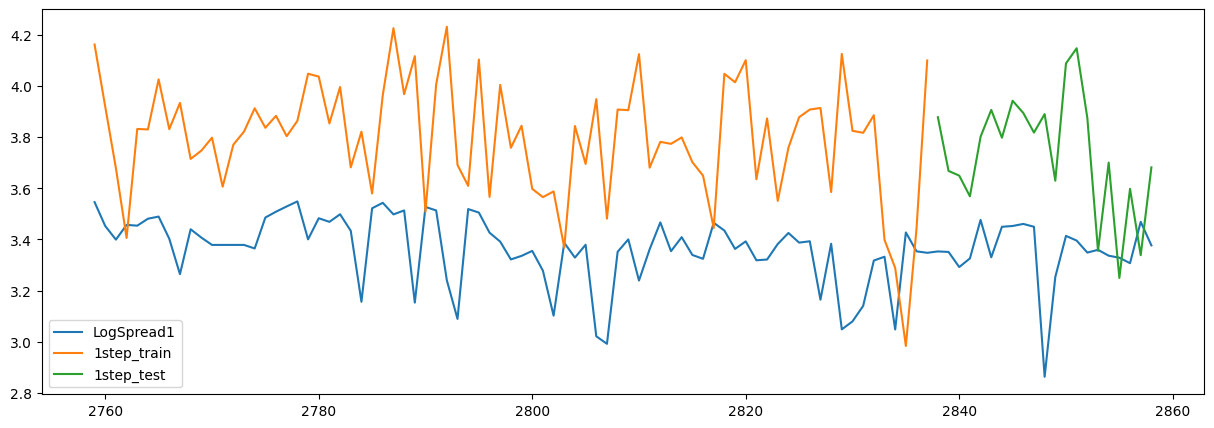

In [27]:
# plot 1-step forecast
df.iloc[-100:][['LogSpread1', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [28]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, D))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 21ms/step


In [29]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

In [30]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

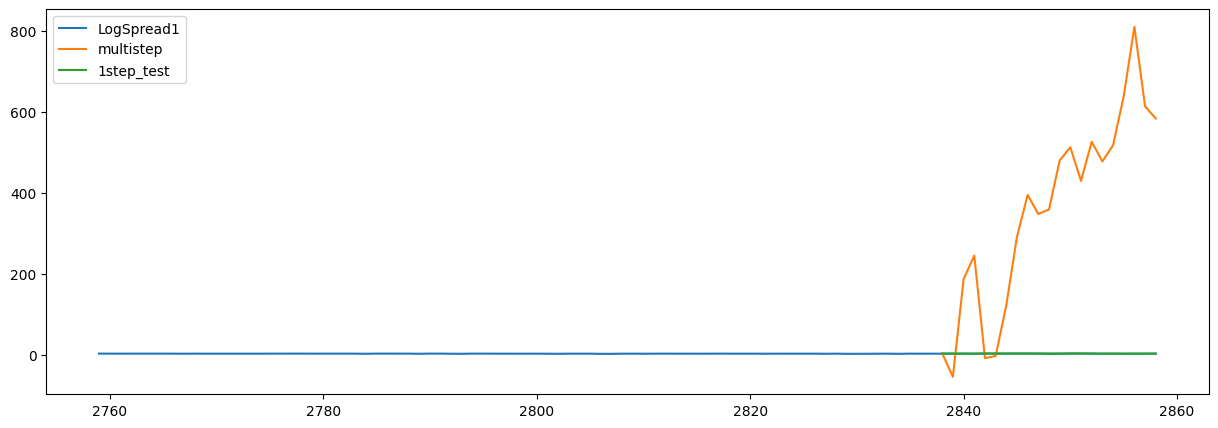

In [31]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [32]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(input_data) - Tx - Ty + 1):
  x = input_data[t:t+Tx]
  X.append(x)
  y = targets[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, D)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2828, 10, 25) Y.shape (2828, 21)


In [33]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [34]:
# CNN
i = Input(shape=(Tx, D))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [35]:
model.compile(
 loss='mse',
 optimizer='adam',
)

In [36]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=500,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/500
89/89 [==============================] - 1s 4ms/step - loss: 4286.3506 - val_loss: 19.7403
Epoch 2/500
89/89 [==============================] - 0s 2ms/step - loss: 16.8925 - val_loss: 5.3558
Epoch 3/500
89/89 [==============================] - 0s 2ms/step - loss: 6.5433 - val_loss: 1.3712
Epoch 4/500
89/89 [==============================] - 0s 2ms/step - loss: 4.4334 - val_loss: 1.6294
Epoch 5/500
89/89 [==============================] - 0s 2ms/step - loss: 4.0459 - val_loss: 1.4122
Epoch 6/500
89/89 [==============================] - 0s 2ms/step - loss: 3.8544 - val_loss: 1.6297
Epoch 7/500
89/89 [==============================] - 0s 2ms/step - loss: 3.6740 - val_loss: 1.1890
Epoch 8/500
89/89 [==============================] - 0s 2ms/step - loss: 3.4824 - val_loss: 1.5732
Epoch 9/500
89/89 [==============================] - 0s 2ms/step - loss: 3.3146 - val_loss: 1.0397
Epoch 10/500
89/89 [==============================] - 0s 3ms/step - loss: 3.0572 - val_loss: 1.0399
Epoc

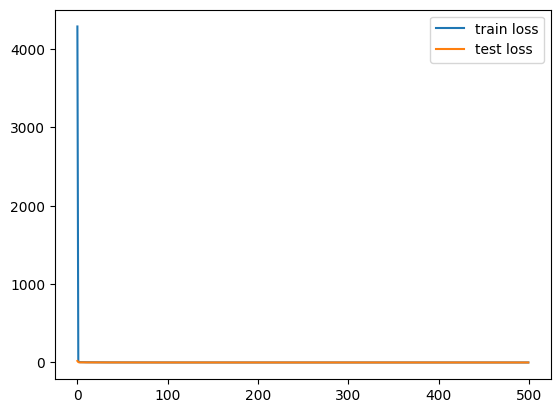

In [37]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [38]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 23ms/step


In [39]:
Ptrain.shape, Ptest.shape

((2827, 21), (1, 21))

In [40]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

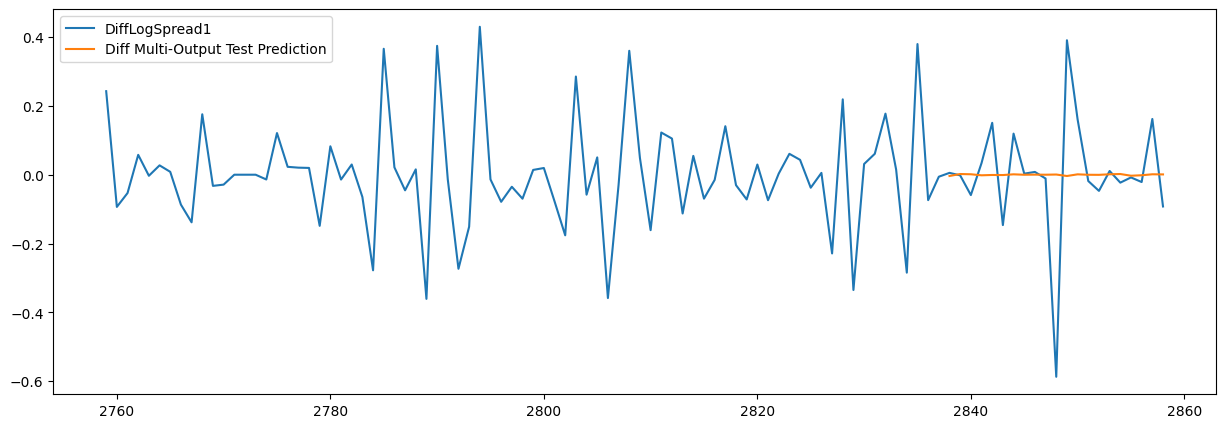

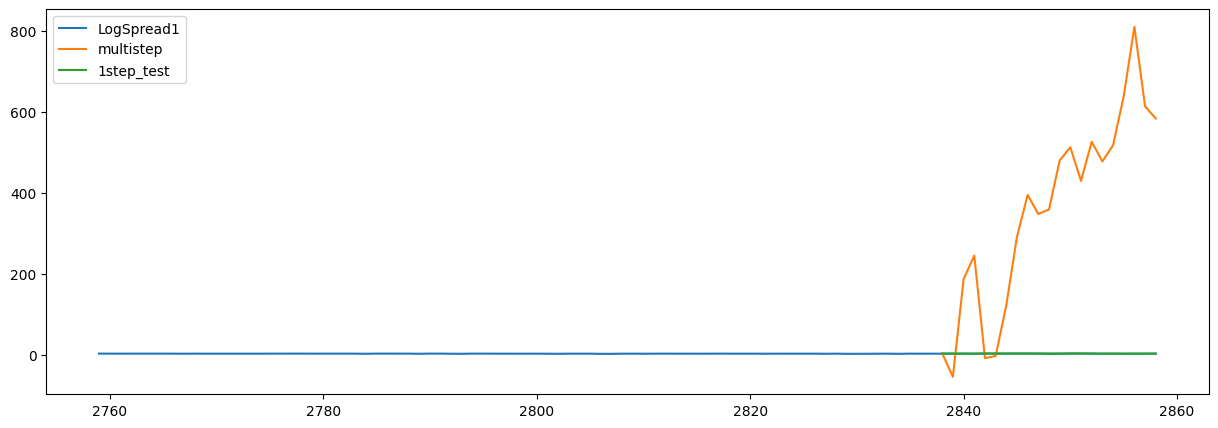

In [41]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogSpread1', 'Diff Multi-Output Test Prediction']
df[-100:][cols].plot(figsize=(15, 5));

df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [42]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
 np.cumsum(Ptest)

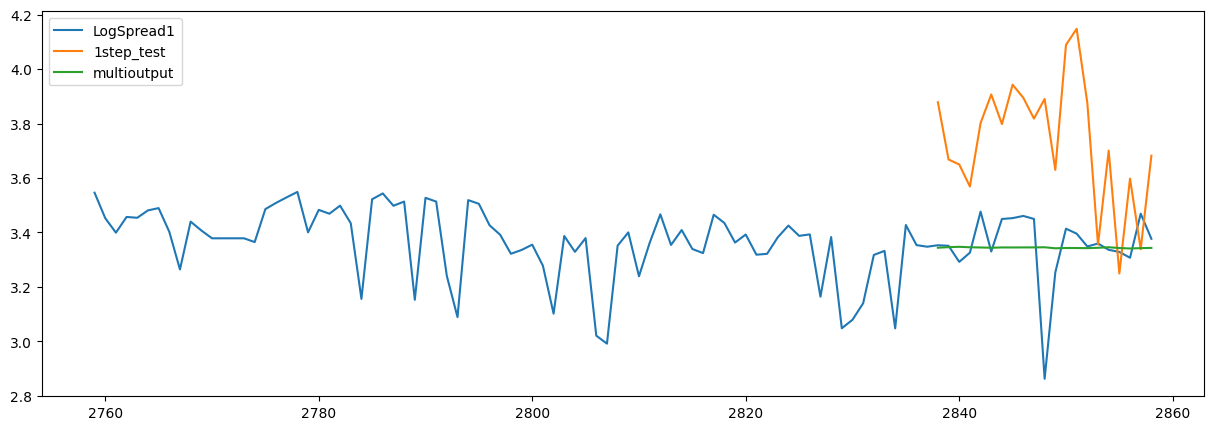

In [43]:
# plot all forecasts '1step_test','multistep'
cols = ['LogSpread1', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [44]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogSpread1']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 107.72685851705931
multi-output MAPE: 0.023663201238059078
